In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import fiddler as fdl

%matplotlib inline

In [2]:
# use the nicer plotting styles from seaborn
sns.set()

In [3]:
%load_ext autoreload
%autoreload 2

# Intro
This notebook assumes you already have the models and data you're interested in using uploaded to Fiddler. Please refer to the previous notebook in this series for more information on uploading to Fiddler. You will also need to have run notebook 1 in order to upload the bikesharing example used in this notebook.

In this notebook we run through a number of other Fiddler functionalities that have been integrated into the Python package. Unlike the previous notebook, there is not as much of a sequential flow to the steps demonstrated here.

## Before you start: set up your API connection

### Launch onebox or authenticate with a remote server
Before you can start working with a Fiddler-integrated Jupyter environment, you should set up access to a running instance of Fiddler.

#### Onebox
In onebox, this means running the `start.sh` script to launch onebox locally.

#### Cloud
For the cloud version of our product, this means looking up your authentication token in the [Fiddler settings dashboard](https://app.fiddler.ai/settings/credentials)

### Create a FiddlerApi object

In order to get your data and models into the Fiddler Engine, you'll need to connect using the API. The `FiddlerApi` object to handles most of the nitty-gritty for you, so all you have to do is specify some details about the Fiddler system you're connecting to.

In [4]:
# NOTE: typically the API url for your running instance of Fiddler will be "https://api.fiddler.ai" (or "http://localhost:4100" for onebox)
# however, use "http://host.docker.internal:4100" as our URL if Jupyter is running in a docker VM on the same macOS machine as onebox
url = 'http://host.docker.internal:4100'

# see <Fiddler URL>/settings/credentials to find, create, or change this token
token = os.getenv('FIDDLER_API_TOKEN')

# see <Fiddler URL>/settings/general to find this id (listed as "Organization Name")
org_id = 'onebox'

fiddler_api = fdl.FiddlerApi(url=url, org_id=org_id, auth_token=token)

## Pulling data from Fiddler

In [5]:
# let's see which datasets we have on Fiddler
fiddler_api.list_datasets()

['imdb_rnn',
 'iris',
 'bank_churn',
 '20news',
 'p2p_loans',
 'winequality',
 'bikeshare']

In [6]:
# the info for any dataset can quickly and easily be fetched with the `dataset_info` method
bikeshare_dataset_info = fiddler_api.get_dataset_info('bikeshare')
bikeshare_dataset_info

DatasetInfo:
  display_name: Bikeshare Dataset
  files: ['train.csv', 'test.csv']
  columns:
            column     dtype count(possible_values)
    0       dteday    STRING                      -
    1       season  CATEGORY                      4
    2           yr   INTEGER                      -
    3         mnth   INTEGER                      -
    4           hr   INTEGER                      -
    5      holiday   BOOLEAN                      -
    6      weekday   INTEGER                      -
    7   workingday   BOOLEAN                      -
    8   weathersit  CATEGORY                      7
    9         temp     FLOAT                      -
    10       atemp     FLOAT                      -
    11         hum     FLOAT                      -
    12   windspeed     FLOAT                      -
    13      casual   INTEGER                      -
    14  registered   INTEGER                      -
    15         cnt   INTEGER                      -

In [7]:
# we can also pull data from the dataset directly into Pandas
bikeshare_dataset = fiddler_api.get_dataset('bikeshare', max_rows=999_999)
print(f'The bikeshare_dataset object is a {type(bikeshare_dataset)} with keys ({list(bikeshare_dataset.keys())})')

df_train = bikeshare_dataset['train']
df_test = bikeshare_dataset['test']

# demo the data
df_train.sample(3, random_state=0).T

The bikeshare_dataset object is a <class 'dict'> with keys (['train', 'test'])


,8326,6451,6429
dteday,2011-12-18,2011-10-01,2011-09-30
season,4,4,4
yr,0,0,0
mnth,12,10,9
hr,15,10,12
holiday,False,False,False
weekday,0,6,5
workingday,False,False,True
weathersit,1,3,2
temp,0.32,0.4,0.64


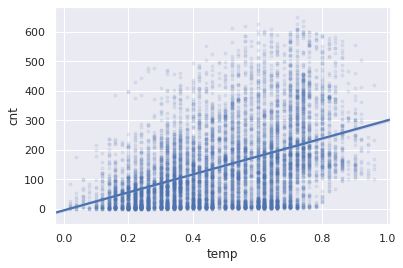

In [8]:
# for example, let's plot a regression plot of the target (cnt) against the temperature feature (temp)
sns.regplot(df_train['temp'], df_train['cnt'], marker='.', scatter_kws=dict(alpha=0.1))

## Using the Fiddler model-builder feature
If you have data but haven't built a model yet, you can take advantage of the model-builder feature to whip up a model instantly so you can dive right into running explanations.

In [9]:
bikeshare_dataset_info.get_column_names()

['dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [10]:
# fiddler_api.delete_model('bikeshare_forecasting', 'generated_bikeshare_model')

In [11]:
# NOTE: to avoid training on the whole dataset, we pass `train_splits`
features = list(set(bikeshare_dataset_info.get_column_names()) - {'casual', 'registered', 'cnt', 'dteday'})
fiddler_api.create_model(project_id='bikeshare_forecasting', 
                         dataset_id='bikeshare',
                         target='cnt',
                         features=features,
                         model_id='generated_bikeshare_model',
                         train_splits=['train'])

{'created_files': {'package.py': 'Wrapper code to run the model on the Fiddler engine',
  'model.yaml': 'Model metadata and configuration',
  'data_processor.py': 'Data cleaning and feature engineering code',
  '__init__.py': 'Empty file. Makes this model directory a python package so the Fiddler engine can run it properly.',
  'model.pkl': 'Serialized model artifact.',
  'processor.pkl': 'Serialized model artifact.',
  'training_features.pkl': 'Serialized training data',
  'train.py': 'Model training script',
  'training_targets.pkl': 'Serialized training data'},
 'project_name': 'bikeshare_forecasting',
 'model_name': 'generated_bikeshare_model'}

In [12]:
# the new model shows up when we list the models in the bikeshare_forecasting project
fiddler_api.list_models(project_id='bikeshare_forecasting')

['knn_model', 'generated_bikeshare_model']

## Explanations in Jupyter
We also support basic integration of our explanation and prediction functionality in Jupyter. The `FiddlerApi` object is your friend here.

In [13]:
# running some predictions on the generated model
fiddler_api.run_model(project_id='bikeshare_forecasting', model_id='generated_bikeshare_model', df=df_test.head(10))

,predicted_cnt
0,17.201259
1,13.841701
2,8.990367
3,0.717645
4,4.031056
5,-2.928235
6,16.928393
7,35.049540
8,47.441858
9,72.827217


In [14]:
# compare against predictions on our kNN model
fiddler_api.run_model(project_id='bikeshare_forecasting', model_id='knn_model', df=df_test.head(10))

,predicted_cnt
0,29.084173
1,21.888947
2,17.315574
3,25.716166
4,26.971802
5,25.599356
6,28.150124
7,28.376281
8,34.132442
9,68.728265


In [16]:
# Run explanations on both models
selected_point = df_test.head(1)
ex_generated = fiddler_api.run_explanation(
    project_id='bikeshare_forecasting',
    model_id='generated_bikeshare_model', 
    df=selected_point, 
    dataset_id='bikeshare')

ex_knn = fiddler_api.run_explanation(
    project_id='bikeshare_forecasting',
    model_id='knn_model', 
    df=selected_point, 
    dataset_id='bikeshare')

Text(0.5, 1.0, 'Top SHAP attributions on first row of bikeshare for generated model')

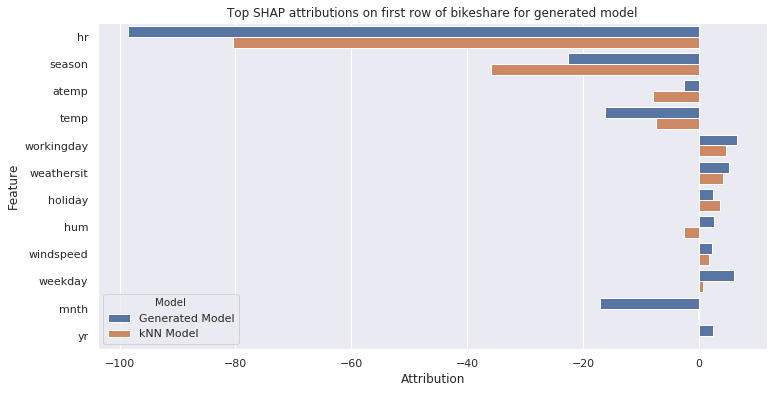

In [17]:
# Create a plot comparing attributions
fig = plt.figure(figsize=(12, 6))
comparison_table = pd.DataFrame({
    'Generated Model': pd.Series(ex_generated.attributions, index=ex_generated.inputs),
    'kNN Model': pd.Series(ex_knn.attributions, index=ex_knn.inputs)
})
comparison_table = comparison_table.loc[comparison_table['kNN Model'].abs().sort_values(ascending=False).index, :]

melted_table = (comparison_table
                .reset_index()
                .rename(columns={'index': 'Feature'})
                .melt(id_vars='Feature', 
                      var_name='Model', 
                      value_name='Attribution'))
sns.barplot(x='Attribution', y='Feature', hue='Model', data=melted_table)

plt.title('Top SHAP attributions on first row of bikeshare for generated model')

# Conclusion
As we have seen in this notebook, once data and models have been deployed to Fiddler, it becomes very easy to share the data, automatically train a model on Fiddler, and run explanations all without leaving